In [1]:
import traffic
from traffic.data import opensky
import matplotlib.pyplot as plt
import xarray
import pickle as pkl
import numpy as np
import joblib as jl

In [ ]:
bounds = (-2.3, 50.5, -0.5, 51.3)
if input() == 'yes':  # prevent this running accidentally!
    soton_tfc = opensky.history(
        "2019-01-01 00:00",
        "2019-02-01 00:00",
        bounds=bounds,
        other_params=' and geoaltitude<=924 and onground=false ')
    soton_tfc.to_pickle("../data/soton_tfc_raw_lt5000ft_201901.pkl")
    soton_tfc_clean = soton_tfc.clean_invalid().assign_id().filter().resample('10s').eval(desc='', max_workers=8)
    soton_tfc_clean.to_pickle("../data/soton_tfc_clean_lt5000ft_201901.pkl")


In [26]:
from glob import glob
import pandas as pd

datas = []
for path in glob('../data/cornwall/cornwall*raw*2019*.pkl'):
    df = pd.read_pickle(path)
    datas.append(traffic.core.Traffic.from_file(path))
tfc_clean = traffic.core.Traffic(pd.concat([tfc.data for tfc in datas]))

In [27]:
tfc_clean = tfc_clean.clean_invalid().assign_id().filter().resample('30s').eval(desc=None, max_workers=12)
tfc_clean.data = tfc_clean.data[tfc_clean.data['altitude'] > 0]
tfc_clean.data = tfc_clean.data.dropna(axis=0)
tfc_clean.data[tfc_clean.data.select_dtypes(np.float64).columns] = tfc_clean.data.select_dtypes(
        np.float64).astype(np.float16)
tfc_clean = tfc_clean.drop(labels=['alert', 'icao24', 'hour', 'callsign', 'onground', 'spi', 'squawk', 'track_unwrapped', 'geoaltitude'], axis=1)

/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/scipy/signal/signaltools.py:1531: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/scipy/signal/signaltools.py:1531: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/scipy/signal/signaltools.py:1531: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the volume will be '
/home/aliaksei/anaconda3/envs/sandbox/lib/python3.10/site-packages/scipy/signal/signaltools.py:1531: UserWarning: kernel_size exceeds volume extent: the volume will be zero-padded.
  warnings.warn('kernel_size exceeds volume extent: the v

In [28]:
tfc_clean.data.describe()

,altitude,groundspeed,latitude,longitude,track,vertical_rate
count,111733.000000,111733.0,111733.00000,111733.000000,111733.0000,111733.0
mean,NaN,NaN,NaN,NaN,NaN,NaN
std,NaN,NaN,0.00000,0.000000,NaN,NaN
min,4.167969,0.0,49.78125,-6.378906,0.0000,-5376.0
25%,1250.000000,100.0,50.18750,-5.535156,91.1875,-448.0
50%,1800.000000,125.0,50.34375,-5.136719,230.8750,-64.0
75%,2700.000000,149.0,50.40625,-4.976562,260.0000,64.0
max,4000.000000,498.0,50.81250,-4.648438,360.0000,4928.0


In [29]:
tfc_clean.to_pickle('../data/cornwall/cornwall_tfc_clean_30s_lt3000ft_2019_f16.pkl.bz2', compression='bz2')

In [4]:
from pyproj import CRS

# print('start 1s resample')
# proj_1s_tfc = tfc_clean.resample('1s').compute_xy(CRS.from_string('EPSG:3857')).eval(
#     max_workers=16).clean_invalid()
# proj_1s_tfc.to_pickle('cornwall_tfc_clean_1s_lt3000ft_2019.pkl')
# print('finish 1s resample')
print('start 10s resample')
proj_30s_tfc = tfc_clean.resample('30s').compute_xy(CRS.from_string('EPSG:27700')).eval(
    max_workers=16).clean_invalid()
proj_30s_tfc.to_pickle('cornwall_tfc_clean_30s_lt3000ft_2019.pkl.bz2',compression='bz2')
print('finish 10s resample')
# print('start 60s resample')
# proj_60s_tfc = tfc_clean.resample('60s').compute_xy(CRS.from_string('EPSG:3857')).eval(
#     max_workers=16).clean_invalid()
# proj_60s_tfc.to_pickle('cornwall_tfc_clean_60s_lt3000ft_2019.pkl')
# print('finish 60s resample')

start 10s resample


AttributeError: 'NaTType' object has no attribute 'tz'

In [ ]:
proj_30s_tfc = traffic.core.Traffic.from_file('../data/cornwall_tfc_clean_30s_lt3000ft_2019_filt10.pkl')

[Text(0.5, 1.0, 'Traffic Data Boxplots')]

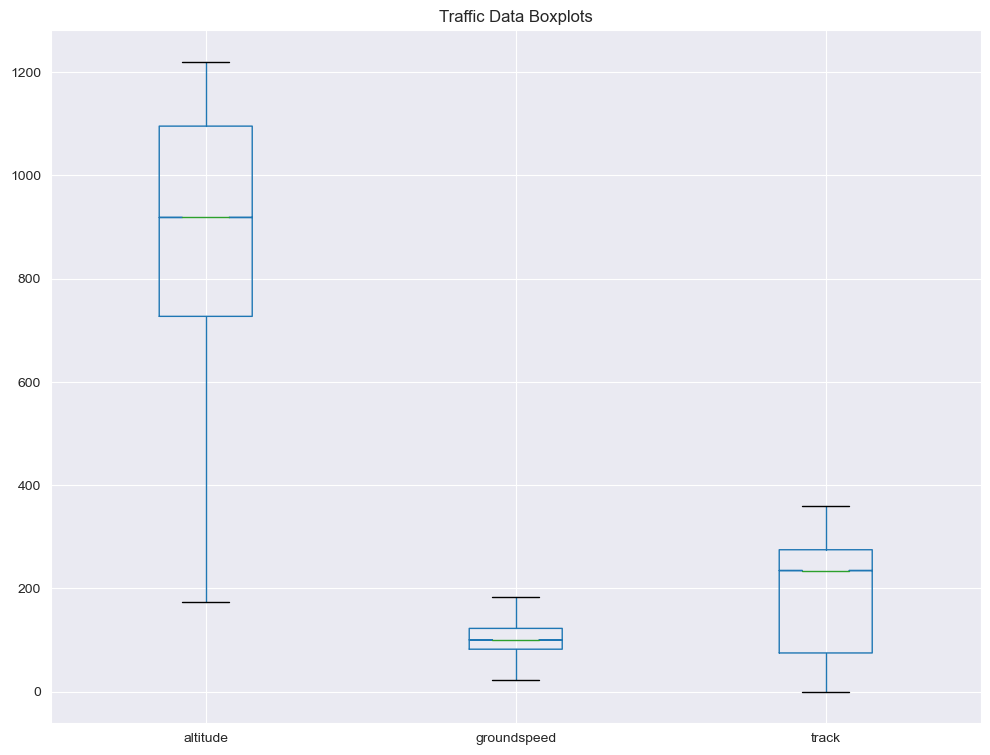

In [5]:
hist_args = dict(alpha=0.5, bins=16, density=True)
fig = plt.figure(figsize=(12, 9))
col_name = 'altitude'
# proj_1s_tfc.data[(proj_1s_tfc.data[col_name] < 1220) & (proj_1s_tfc.data[col_name] > 0)][col_name].hist(**hist_args,
#                                                                                                         label='1sec sample rate')
# proj_10s_tfc.data[(proj_10s_tfc.data[col_name] < 1220) & (proj_10s_tfc.data[col_name] > 0)][col_name].hist(**hist_args,
#                                                                                                            label='10sec sample rate')
proj_60s_tfc.data[(proj_60s_tfc.data[col_name] < 1220) & (proj_60s_tfc.data[col_name] > 0)].boxplot(
    column=['altitude', 'groundspeed', 'track',], notch=True, sym='')

plt.gca().set(title='Traffic Data Boxplots')
# plt.vlines(304.8, *plt.ylim(), 'r')
# plt.vlines(304.8 * 2, *plt.ylim(), 'r')
# plt.vlines(304.8 * 3, *plt.ylim(), 'r')
# plt.vlines(304.8 * 4, *plt.ylim(), 'r')
# plt.legend()

In [ ]:
import seaborn as sns

corr = proj_60s_tfc.data.corr(method='spearman')
fig, ax = plt.subplots(figsize=(15, 15))
sns.heatmap(corr, square=True, cmap=sns.color_palette('inferno', as_cmap=True), annot=True, ax=ax)

In [ ]:
proj_1s_tfc = proj_60s_tfc
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
proj_1s_tfc.data['track'] = proj_1s_tfc.data['track_unwrapped'].mod(360)
proj_1s_tfc.data = proj_1s_tfc.data[(proj_1s_tfc.data['altitude'] < 1220) & (proj_1s_tfc.data['altitude'] > 0)]
proj_1s_tfc.data.plot('track', 'altitude', kind='hexbin', gridsize=36, ax=ax, cmap='inferno', bins='log')
plt.gca().set(title='Track vs Altitude Log Freq', xlabel='Track [deg]', ylabel='Altitude [m]', )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
proj_1s_tfc.data[(proj_1s_tfc.data['vertical_rate'] < 1500) & (proj_1s_tfc.data['vertical_rate'] > -1500)].plot('vertical_rate', 'altitude', kind='hexbin', gridsize=36, ax=ax, cmap='inferno', bins='log')
plt.gca().set(title='Vertical Rate vs Altitude Log Freq', xlabel='Vertical Rate [ft/min]', ylabel='Altitude [m]', )

In [ ]:
fig, ax = plt.subplots(1, 1, figsize=(10, 8))
proj_1s_tfc.data[(proj_1s_tfc.data['groundspeed'] < 250)].plot('groundspeed', 'altitude', kind='hexbin', gridsize=36, ax=ax, cmap='inferno', bins='log')
plt.gca().set(title='Groundspeed vs Altitude Log Freq', xlabel='Groundspeed [kts]', ylabel='Altitude [m]', )

In [ ]:
import matplotlib as mpl
from cartes.crs import LambertConformal, Projection, EPSG_3857, EPSG_27700
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports
from mpl_toolkits.basemap import Basemap

mpl.rc('font', size=20)
fig = plt.figure(figsize=(10, 8))
ax = fig.add_axes([0, 0, 6, 6])
axx = fig.add_axes([0, 6.1, 4.8, 1], sharex=ax)
axy = fig.add_axes([6.1, 0, 1, 6], sharey=ax)
proj_60s_tfc.data.plot('x', 'y', kind='hexbin', gridsize=200, bins='log', ax=ax, cmap='inferno')
proj_60s_tfc.data['x'].hist(ax=axx, bins=32)
proj_60s_tfc.data['y'].hist(ax=axy, orientation='horizontal', bins=32)

# ax.add_feature(countries())
# ax.add_feature(lakes())
# ax.add_feature(ocean())

# airports['EGHQ'].point.plot(ax)
# airports['EGHE'].point.plot(ax)
# airports['EGHC'].point.plot(ax)

fig.show()

In [ ]:
hist_args = dict(alpha=0.5, bins=16, density=True)
fig = plt.figure(figsize=(10, 7))
col_name = 'track'
proj_60s_tfc.data[(proj_60s_tfc.data[col_name] < 1220) & (proj_60s_tfc.data[col_name] > 0)][col_name].hist(**hist_args,label='60sec sample rate')
plt.gca().set(title='Track Bearing Histogram', ylabel='Frequency Density', xlabel='Track [deg]')

In [ ]:
import pandas as pd
alt_groups = proj_60s_tfc.data.groupby(pd.cut(proj_60s_tfc.data['altitude'], np.linspace(0,1220, 8)))
alt_groups.head()

In [ ]:
import pickle
with open('../data/cornwall_tfc_30s_lt3000ft_2019_pd_alt_groupby.pkl', 'wb') as f:
    pickle.dump(alt_groups, f)

In [ ]:
axy = proj_60s_tfc.compute_xy().agg_xy(resolution=dict(x=2000, y=2000), altitude='min', track='mean', groundspeed='mean')
axy.shape

In [ ]:
proj_60s_tfc.data.drop(labels='track_unwrapped', inplace=True, axis=1)
proj_60s_tfc.data.columns

In [ ]:
from cartes.crs import LambertConformal, EPSG_27700, PlateCarree, EuroPP, Mercator
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports
bounds = (-6.5, -3.65, 49.58, 50.95)

with plt.style.context("traffic"):
    fig, ax = plt.subplots(
        1, 1, figsize=(12,10), dpi=600,
        subplot_kw=dict(projection=Mercator()),
    )

    ax.add_feature(countries())
    ax.add_feature(lakes())
    ax.add_feature(ocean())

    # ax.set_extent(bounds)

    airports['EGHQ'].point.plot(ax)
    airports['EGHE'].point.plot(ax)
    airports['EGHC'].point.plot(ax)

    axy['altitude'].to_xarray().plot.pcolormesh(
        ax=ax,
        alpha=0.4,
        cmap="inferno",
        transform='lcc',
    )
    fig.show()

In [ ]:
fig = plt.figure(figsize=(10, 7))
axy.reset_index().plot('x', 'y', kind='hexbin', gridsize=2000)

In [ ]:
from cartes.crs import LambertConformal
from traffic.drawing import countries, lakes, ocean
from traffic.data import airports

fig, ax = plt.subplots(
    1, 1, figsize=(10, 8), dpi=300,
    subplot_kw=dict(projection=LambertConformal(-5, 50)),
)

ax.add_feature(countries())
ax.add_feature(lakes())
ax.add_feature(ocean())

airports['EGHQ'].point.plot(ax)
airports['EGHE'].point.plot(ax)
airports['EGHC'].point.plot(ax)

proj_1s_tfc.plot(ax)
fig.show()

In [ ]:
z_res = 152  #m ~= 500ft
z_floor = 0  # min altitude
z_ceiling = 1220  # max altitude from openSky query above

# Create (lower, upper) bound pairs for queries
zs = list(range(z_floor, z_ceiling, z_res))
z_limit_pairs = list(zip(zs, zs[1:]))  # generated for later

# data = tfc_clean#.resample('1s').eval(max_workers=16)
data = proj_60s_tfc

z_layer_data = []
for lower, upper in z_limit_pairs:
    z_layer_data.append(data.query(f'altitude>{lower} and altitude<={upper}'))

In [ ]:
# The data is a full year and 2019 is not a leap year so...
hours = 365 * 24
# Crudely assume that half of those are daylight hours and the other half night
day_hours = night_hours = hours / 2

In [ ]:
# dimension resolutions
rlat = 500
rlon = 500

layer_rasters = []
for i, d in enumerate(z_layer_data):
    layer_raster = d.agg_latlon(
        resolution=dict(latitude=rlat, longitude=rlon),
        # count the number of flights
        flight_id="nunique"
    ).to_xarray()
    layer_rasters.append(layer_raster)

In [ ]:
import shapely.geometry as sg
from pyproj import Transformer

tr = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
tr_layer_rasters = []

for layer in layer_rasters:
    lons, lats = np.meshgrid(layer.longitude, layer.latitude)
    tr_lon, tr_lat = tr.transform(lons, lats)
    tr_lat = tr_lat[:, 0]
    tr_lon = tr_lon[0, :]

    poly_areas = []
    for idx_lat, t_lat in np.ndenumerate(tr_lat[:-1]):
        lat_areas = []
        b_lat = tr_lat[idx_lat[0] + 1]
        for idx_lon, l_lon in np.ndenumerate(tr_lon[:-1]):
            r_lon = tr_lon[idx_lon[0] + 1]
            poly = sg.box(l_lon, b_lat, r_lon, t_lat)
            lat_areas.append(poly.area)

        # Repeat final elements to fill in gaps and index correctly
        # For small areas the error this introduces is negligible
        lat_areas.append(lat_areas[-1])

        poly_areas.append(lat_areas)
    poly_areas.append(poly_areas[-1])
    # Now that we have the area of each pixel we can find the volume that each layer increment has
    raster_vols = np.array(poly_areas) * z_res
    tr_layer_rasters.append(layer)  # / (raster_vols * hours))

In [ ]:
layer_rasters[0]

In [ ]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from cartes.crs import PlateCarree, LambertConformal, EPSG_3857
from traffic.data import airports
from traffic.drawing import countries, ocean
from traffic.drawing.markers import rotate_marker, atc_tower, aircraft

# layer_rasters = []

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(150, 100), frameon=False)
    ax = fig.subplots(len(z_layer_data), 1, subplot_kw=dict(projection=EuroPP()))

    for ax_ in ax:
        ax_.add_feature(countries())
        ax_.add_feature(lakes())
        ax_.add_feature(ocean())
        # ax_.background_patch.set_facecolor("#eeeeee")
        for name in "EGHE EGHC EGDR EGHQ".split():
            # bbox = dict(
            #     facecolor="green", edgecolor="green", alpha=0.6, boxstyle="round"
            # )
            airports[name].point.plot(ax_, marker=atc_tower, s=500, zorder=5)
        # ax_.set(ylim=[49.78, 50.85], xlim=[-6.5, -4.65])

    vmax = None  # this trick will keep the same colorbar scale for both maps

    for i, layer_raster in enumerate(layer_rasters):
        #         layer_raster = data.agg_latlon(
        #                 resolution=dict(latitude=nlat, longitude=nlon),
        #                 # count the number of flights
        #                 flight_id="nunique"
        #                 ).to_xarray() / premult# Normalise by volume and time
        #         layer_rasters.append(layer_raster)
        cax = (
            layer_raster
            .flight_id.plot.pcolormesh(
                ax=ax[i],
                cmap="inferno",
                transform=PlateCarree(),
                vmax=vmax,
                add_colorbar=False,
            )
        )

        cbaxes = inset_axes(ax[i], "4%", "60%", loc=3)
        cb = fig.colorbar(cax, cax=cbaxes)

        # keep this value to scale the colorbar for the second day
        vmax = cb.vmax

        text = AnchoredText(
            f"Altitude: {z_limit_pairs[i][0]}m - {z_limit_pairs[i][1]}m",
            loc=2,
            prop={"size": 14, "fontname": "Ubuntu"},
            frameon=True,
        )
        text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
        ax[i].add_artist(text)

    fig.set_tight_layout(True)

In [ ]:
!conda install -y rasterio

In [ ]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from traffic.drawing import countries, ocean

with plt.style.context("traffic"):
    fig = plt.figure(figsize=(15, 10), frameon=False)
    ax = fig.subplots(1, 1, subplot_kw=dict(projection=PlateCarree()))

    ax.add_feature(countries(scale="50m", linewidth=1.5))
    ax.background_patch.set_facecolor("#eeeeee")

    vmax = None  # this trick will keep the same colorbar scale for both maps

    data = z_layer_data[0]
    cax = (
        data
        .agg_latlon(
            resolution=dict(latitude=300, longitude=300),
            # count the number of flights
            flight_id="nunique"
        )
        .to_xarray()
        .flight_id.plot.pcolormesh(
            ax=ax,
            cmap="YlOrBr",
            transform=PlateCarree(),
            vmax=vmax,
            add_colorbar=False,
        )
    )

    cbaxes = inset_axes(ax, "4%", "60%", loc=3)
    cb = fig.colorbar(cax, cax=cbaxes)

    # keep this value to scale the colorbar for the second day
    vmax = cb.vmax

    text = AnchoredText(
        f"{data.start_time:%B %d, %Y}",
        loc=1,
        prop={"size": 24, "fontname": "Ubuntu"},
        frameon=True,
    )
    text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
    ax.add_artist(text)

    fig.set_tight_layout(True)

In [ ]:
import holoviews as hv
import geoviews as gv
import bokeh
import panel as pn

hv.extension('bokeh')
gv.extension('bokeh', 'matplotlib')

In [ ]:
layer_rasters

In [ ]:
hmap = hv.HoloMap(
    {f"{z_limit_pairs[i][0]}m - {z_limit_pairs[i][1]}m": gv.QuadMesh(np.log10(layer_rasters[i]),
                                                                     kdims=['longitude', 'latitude']).opts(alpha=0.8,
                                                                                                           clipping_colors={
                                                                                                               'NaN': 'transparent'},
                                                                                                           colorbar=True,
                                                                                                           colorbar_opts={
                                                                                                               'title': "Log10 Traffic Density [log10 m^−3]"},
                                                                                                           cmap='inferno')
     for i in range(len(layer_rasters))},
    kdims='Altitude')
tiles = gv.tile_sources.OSM
plot = (tiles * hmap).opts(width=600, height=550, active_tools=['wheel_zoom'])
plot
hv.save(plot, 'cornwall_air_tfc_count_2019_01.html', backend='bokeh')

## Time based traffic

In [ ]:
from tqdm import tqdm
import time
from calendar import timegm

start_epoch = timegm(time.strptime("2019-01-01 00:00", '%Y-%m-%d %H:%M'))
end_epoch = timegm(time.strptime("2020-01-01 00:00", '%Y-%m-%d %H:%M'))

sec_in_hour = 60 ** 2
sec_in_day = 60 * 60 * 24
hour_epochs = []
for h in range(24):
    hour_epochs.append(np.arange(start_epoch + (h * sec_in_hour), end_epoch, sec_in_day))

hour_epochs[0][:5]

In [ ]:
def traj_between(start, end):
    out = []
    out_append = out.append
    for f in soton_tfc_clean:
        t = f.between(start, end)
        if t:
            out_append(t)
    return out

In [ ]:
from tqdm import tqdm
from joblib import Parallel, delayed

year_hour_trajectories = []
for hour in tqdm(range(24)):
    hour_traj = []
    start_end_pairs = []
    for day in range(21):
        start = hour_epochs[hour][day]
        end = hour_epochs[(hour + 1) % 24][day]
        start_end_pairs.append((start, end))
    hour_traj = Parallel(n_jobs=-1)(delayed(traj_between)(s, e) for s, e in tqdm(start_end_pairs))
    year_hour_trajectories.append(hour_traj)


In [ ]:
yht = year_hour_trajectories

In [ ]:
with open('3_week_hour_traj.pkl', 'wb') as f:
    pkl.dump(year_hour_trajectories, f)

In [ ]:
with open('3_week_hour_traj.pkl', 'rb') as f:
    year_hour_trajectories = pkl.load(f)

In [ ]:
from traffic.core import Flight

[f[0] for f in year_hour_trajectories[5] if f][0].latitude

In [ ]:
from traffic.core import Traffic

hour_traffics = []
for hour in range(24):
    ttft = Traffic.from_flights([f[0] for f in yht[hour] if f])
    if ttft:
        hour_traffics.append(ttft)
    else:
        hour_traffics.append([])

In [ ]:
hour_traffics[23]

In [ ]:
# dimension resolutions
rlat = 150
rlon = 150

hour_rasters = []
for hour_data in tqdm(hour_traffics):
    z_layer_data = []
    if not hour_data:
        hour_rasters.append([])
        continue
    for lower, upper in z_limit_pairs:
        z_layer_data.append(hour_data.query(f'altitude>{lower} and altitude<={upper}'))

        layer_rasters = []
        for i, data in enumerate(z_layer_data):
            if data:
                layer_raster = data.agg_latlon(
                    resolution=dict(latitude=rlat, longitude=rlon),
                    # count the number of flights
                    flight_id="nunique"
                ).to_xarray()
                layer_rasters.append(layer_raster)
    hour_rasters.append(layer_rasters)

In [ ]:
import shapely.geometry as sg
from pyproj import Transformer

tr = Transformer.from_crs('EPSG:4326', 'EPSG:3857', always_xy=True)
tr_hour_rasters = []
for hour in range(24):
    tr_layer_rasters = []
    for layer in hour_rasters[hour]:
        print(len(layer))
        print(len(layer.latitude))
        lons, lats = np.meshgrid(layer.longitude, layer.latitude)
        tr_lon, tr_lat = tr.transform(lons, lats)
        tr_lat = tr_lat[:, 0]
        tr_lon = tr_lon[0, :]

        poly_areas = []
        for idx_lat, t_lat in np.ndenumerate(tr_lat[:-1]):
            lat_areas = []
            b_lat = tr_lat[idx_lat[0] + 1]
            for idx_lon, l_lon in np.ndenumerate(tr_lon[:-1]):
                r_lon = tr_lon[idx_lon[0] + 1]
                poly = sg.box(l_lon, b_lat, r_lon, t_lat)
                lat_areas.append(poly.area)

            # Repeat final elements to fill in gaps and index correctly
            # For small areas the error this introduces is negligible
            lat_areas.append(lat_areas[-1])

            poly_areas.append(lat_areas)
        if poly_areas:
            poly_areas.append(poly_areas[-1])
            # Now that we have the area of each pixel we can find the volume that each layer increment has
            raster_vols = np.array(poly_areas) * z_res
            tr_layer_rasters.append(layer / (raster_vols * hours))
    if tr_layer_rasters:
        tr_hour_rasters.append(tr_layer_rasters)

In [ ]:
import holoviews as hv
import geoviews as gv


def getHourRaster(hour, alt):
    try:
        return gv.QuadMesh(np.log10(hour_rasters[hour][alt]))
    except IndexError:
        return None


kdims = [hv.Dimension(('hour', 'Hour')),
         hv.Dimension(('alt', 'Altitude'))]
timed_tfc_rasters = {(hour, alt): getHourRaster(hour, alt) for hour in range(23) for alt in
                     range(len(z_limit_pairs) - 1)}
hmap = hv.HoloMap(timed_tfc_rasters, kdims=kdims).opts(alpha=0.8, clipping_colors={'NaN': 'transparent'}, colorbar=True,
                                                       colorbar_opts={
                                                           'title': "Log10 Traffic Density [log10 m^−3 . h^−1]"},
                                                       cmap='inferno')
tiles = gv.tile_sources.OSM
plot = (tiles * hmap).opts(width=600, height=550, active_tools=['wheel_zoom'])
plot
# hv.save(plot, 'soton_air_tfc_density_2019.html', backend='bokeh')

In [ ]:
from matplotlib.offsetbox import AnchoredText
from mpl_toolkits.axes_grid1.inset_locator import inset_axes

from traffic.data import airports
from traffic.drawing import countries, ocean, EuroPP, PlateCarree
from traffic.drawing.markers import rotate_marker, atc_tower, aircraft

layer_rasters = []

with plt.style.context("traffic"):
    for hour in range(24):
        print("########## Hour: ", hour)
        if len(hour_rasters[hour]) == 0:
            print("Skipping empty")
            continue

        fig = plt.figure(figsize=(150, 100), frameon=False)
        ax = fig.subplots(len(hour_rasters[hour]), 1, subplot_kw=dict(projection=PlateCarree()))

        if len(hour_rasters[hour]) == 1:
            ax = [ax]
            print(ax)

        for ax_ in ax:
            ax_.add_feature(countries(scale="50m", linewidth=1.5))
            ax_.background_patch.set_facecolor("#eeeeee")
            for name in "EGHI EGHH EGLF EGDM".split():
                bbox = dict(
                    facecolor="green", edgecolor="green", alpha=0.6, boxstyle="round"
                )
                airports[name].point.plot(ax_, marker=atc_tower, s=500, zorder=5)

        vmax = None  # this trick will keep the same colorbar scale for both maps

        for i, layer_raster in enumerate(hour_rasters[hour]):
            #         layer_raster = data.agg_latlon(
            #                 resolution=dict(latitude=nlat, longitude=nlon),
            #                 # count the number of flights
            #                 flight_id="nunique"
            #                 ).to_xarray() / premult# Normalise by volume and time
            #         layer_rasters.append(layer_raster)
            cax = (
                layer_raster
                .flight_id.plot.pcolormesh(
                    ax=ax[i],
                    cmap="inferno",
                    transform=PlateCarree(),
                    vmax=vmax,
                    add_colorbar=False,
                )
            )

            cbaxes = inset_axes(ax[i], "4%", "60%", loc=3)
            cb = fig.colorbar(cax, cax=cbaxes)

            # keep this value to scale the colorbar for the second day
            vmax = cb.vmax

            text = AnchoredText(
                f"Altitude: {z_limit_pairs[i][0]}m - {z_limit_pairs[i][1]}m\nHour:{hour}",
                loc=2,
                prop={"size": 14, "fontname": "Ubuntu"},
                frameon=True,
            )
            text.patch.set_boxstyle("round,pad=0.,rounding_size=0.2")
            ax[i].add_artist(text)

        fig.set_tight_layout(True)
        fig.show()